In [8]:
import instruments as inst
import copy
import numpy as np
import json

# Step 1.a): Reading in csv - extracting single diffs and sums and configurations

In [9]:
file_path = "20230914_processed_table.csv"
wavelength_string = "750-50"
obs_mode = "IPOL"

interleaved_values, interleaved_stds, configuration_list = inst.read_csv(file_path, 
    obs_mode = obs_mode, obs_filter = wavelength_string)
# print("Interleaved Values")
# print("Length: ", len(interleaved_values))
# print(interleaved_values)
# print("Interleaved Stds")
# print("Length: ", len(interleaved_stds))
# print(interleaved_stds[0 : 10])
# print("Configuration List")
# print("Length: ", len(configuration_list))
# print(configuration_list)
# print(interleaved_stds[0])

# Step 1.b) - Make plot of existing values as double diffs and sums

# Step 2: Creating a system Mueller matrix object

In [10]:
import numpy as np
past_fit = np.load("scipy_minimize_20230914_720nm_restrictive_HWP_and_IMR.npy")
print("Past Fit: ", past_fit)

Past Fit:  [ 4.99984042  0.44887049  1.08704114  0.40140005 -4.99999346 -0.21697373
  0.09999933 21.36101844  0.51787551  0.43110147  1.18869275]


In [11]:
# Loading in previous fit from vampires_calibration
theta_pol = 3.7076542079106227
delta_HWP = 0.4697049286003256
offset_HWP = 4.999999990748636
delta_derot = 0.4916825631067103
delta_opts = 0.26448475654868386
epsilon_opts = 7.690580740080888e-11
rot_opts = -5.517409523967533
delta_FLC = 0.4846529161283035
rot_FLC = 4.999999998290983
em_gain = 1.1885854840108756

# Based on values in Six_And_Eleven_Parameter_Model_Best_MCMC_and_Scipy_Fits Google Sheets - having zeros for angles that're too large
# theta_pol = 0
# delta_HWP = 0.451  # Add your actual delta_HWP value
# offset_HWP = -2.64  # Add your actual offset_HWP value
# delta_derot = 0.32  # Add your actual delta_derot value
# offset_derot = 0  # Add your actual offset_derot value
# delta_opts = 0  # Add your actual delta_opts value
# epsilon_opts = 0  # Add your actual epsilon_opts value
# rot_opts = 0  # Add your actual rot_opts value
# delta_FLC = 0.5  # Add your actual delta_FLC value
# rot_FLC = 0  # Add your actual rot_FLC value
# em_gain = 1.2  # Add your actual em_gain value

# NOTE: Components must be listed downstream to upstream
# Define the instrument configuration as a system dictionary


system_dict = {
    "components": {
        "wollaston": {
            "type": "wollaston_prism_function",
            "properties": {"beam": "o", "transmission_ratio": em_gain},
        },
        "dichroic": {
            "type": "diattenuator_retarder_function",
            "properties": {'phi': 0, 'epsilon': 0, 'theta': 0},
        },
        "flc": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_FLC, "theta": 0, "delta_theta": rot_FLC},
        },
        "optics": {
            "type": "diattenuator_retarder_function",
            "properties": {'phi': 2 * np.pi * delta_opts, 'epsilon': epsilon_opts, 'theta': rot_opts},
        },
        "image_rotator": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_derot, "theta": 0, "delta_theta": 0},
        },
        "hwp": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_HWP, "theta": 0, "delta_theta": offset_HWP},
        },
        "lp": {
            "type": "general_linear_polarizer_function_with_theta",
            "properties": {"theta": theta_pol},
        },
    }
}

print(system_dict)

{'components': {'wollaston': {'type': 'wollaston_prism_function', 'properties': {'beam': 'o', 'transmission_ratio': 1.1885854840108756}}, 'dichroic': {'type': 'diattenuator_retarder_function', 'properties': {'phi': 0, 'epsilon': 0, 'theta': 0}}, 'flc': {'type': 'general_retarder_function', 'properties': {'phi': 3.045164081699097, 'theta': 0, 'delta_theta': 4.999999998290983}}, 'optics': {'type': 'diattenuator_retarder_function', 'properties': {'phi': 1.6618067363196602, 'epsilon': 7.690580740080888e-11, 'theta': -5.517409523967533}}, 'image_rotator': {'type': 'general_retarder_function', 'properties': {'phi': 3.089332656308482, 'theta': 0, 'delta_theta': 0}}, 'hwp': {'type': 'general_retarder_function', 'properties': {'phi': 2.951243106091402, 'theta': 0, 'delta_theta': 4.999999990748636}}, 'lp': {'type': 'general_linear_polarizer_function_with_theta', 'properties': {'theta': 3.7076542079106227}}}}


In [12]:
# Converting system dictionary into system Mueller Matrix object

system_mm = inst.generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())

[[0.54890437 0.54431373 0.0708419  0.        ]
 [0.54890437 0.54431373 0.0708419  0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


# Step 4: Creating a dictionary of p0 starting guesses

logl value: 1555.4321657371574


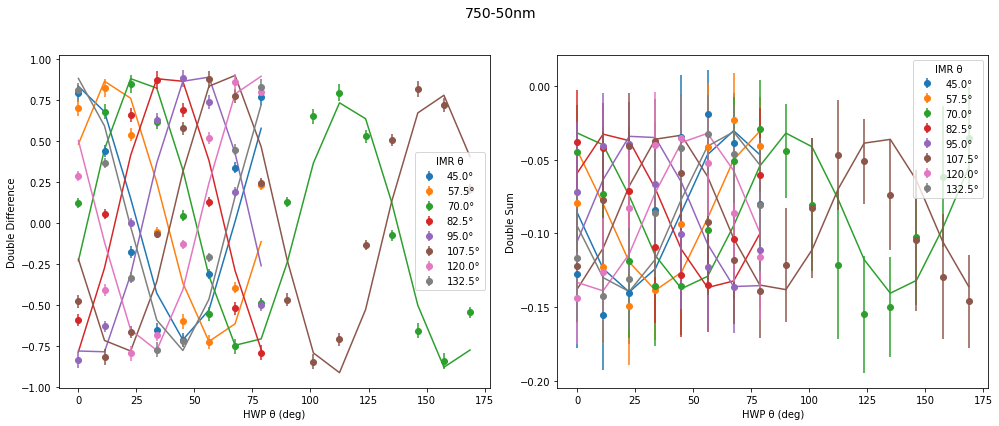

In [13]:
# Fittin for all parameters

p0 = {
    "wollaston": {"transmission_ratio": em_gain}, 
    "dichroic": {"phi": 0, 
                 "epsilon": 0, 
                 "theta": 0},
    "flc": {"phi": 2 * np.pi * delta_FLC, "delta_theta": rot_FLC},
    "optics": {"phi": 2 * np.pi * delta_opts, "epsilon": epsilon_opts, "theta": rot_opts},
    "image_rotator": {
                    "phi": 2 * np.pi * delta_derot, 
                    # "delta_theta": 0
                    },
    "hwp": {"phi": 2 * np.pi * delta_HWP, "delta_theta": offset_HWP},
    "lp": {"theta": theta_pol}
}

p0_values, p0_keywords = inst.parse_configuration(p0)
s_in = np.array([1, 0, 0, 0])
logl_value = inst.logl(p0_values, p0_keywords, system_mm, interleaved_values, interleaved_stds, configuration_list,
    s_in=s_in, logl_function=None, process_dataset=inst.process_dataset, process_errors=inst.process_errors, 
    process_model=inst.process_model)
print("logl value: " + str(logl_value))

# TODO: Add an initial plot block here
# Plotting intial plot
updated_system_mm = inst.update_system_mm(p0_values, p0_keywords, system_mm)
model = inst.model(p0_values, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)

inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
    configuration_list, wavelength = wavelength_string)

# Step 5: Running minimize_system_Mueller_matrix iteratively

Before p0: {'wollaston': {'transmission_ratio': 1.1885854840108756}, 'dichroic': {'phi': 0, 'epsilon': 0, 'theta': 0}, 'flc': {'phi': 3.045164081699097, 'delta_theta': 4.999999998290983}, 'optics': {'phi': 1.6618067363196602, 'epsilon': 7.690580740080888e-11, 'theta': -5.517409523967533}, 'image_rotator': {'phi': 3.089332656308482}, 'hwp': {'phi': 2.951243106091402, 'delta_theta': 4.999999990748636}, 'lp': {'theta': 3.7076542079106227}}


Iteration #: 1
logl_value: 55.54269907729572
Best Fit Parameters: [ 1.17791845e+00  1.29267752e-02  4.10106242e-03 -2.18282626e-03
  3.05385099e+00  4.99999480e+00  1.34245630e+00  2.67672004e-10
 -5.88716608e+00  3.07092858e+00  3.00317639e+00  4.99998919e+00
 -1.43535109e+00]


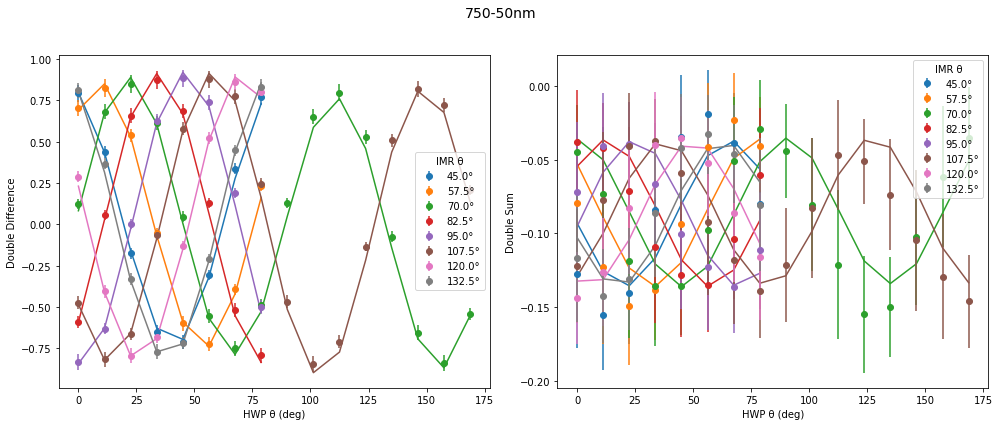

After p0: {'wollaston': {'transmission_ratio': 1.177918447349367}, 'dichroic': {'phi': 0.012926775216665562, 'epsilon': 0.004101062423785976, 'theta': -0.002182826256143808}, 'flc': {'phi': 3.0538509860903824, 'delta_theta': 4.999994799797571}, 'optics': {'phi': 1.3424562988882252, 'epsilon': 2.6767200394649626e-10, 'theta': -5.88716607900918}, 'image_rotator': {'phi': 3.0709285757595284}, 'hwp': {'phi': 3.003176387751113, 'delta_theta': 4.999989189074116}, 'lp': {'theta': -1.435351089390144}}
Before p0: {'wollaston': {'transmission_ratio': 1.177918447349367}, 'dichroic': {'phi': 0.012926775216665562, 'epsilon': 0.004101062423785976, 'theta': -0.002182826256143808}, 'flc': {'phi': 3.0538509860903824, 'delta_theta': 4.999994799797571}, 'optics': {'phi': 1.3424562988882252, 'epsilon': 2.6767200394649626e-10, 'theta': -5.88716607900918}, 'image_rotator': {'phi': 3.0709285757595284}, 'hwp': {'phi': 3.003176387751113, 'delta_theta': 4.999989189074116}, 'lp': {'theta': -1.435351089390144}}
I

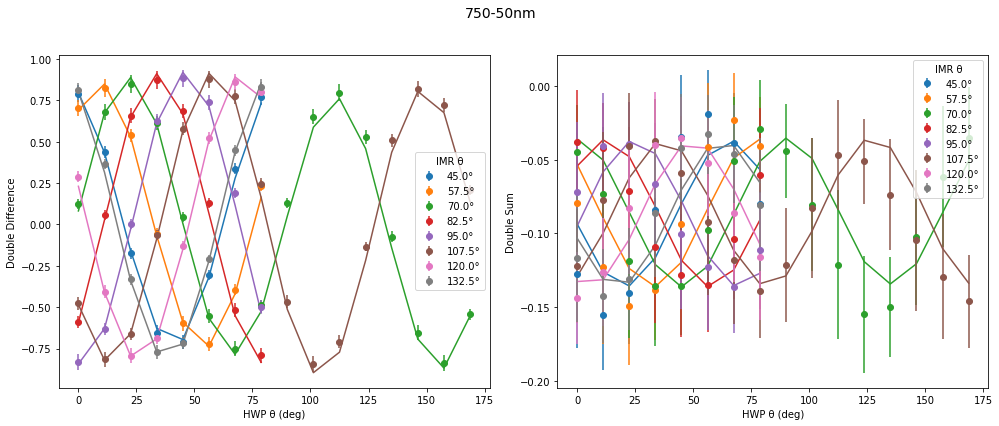

After p0: {'wollaston': {'transmission_ratio': 1.0918286420719308}, 'dichroic': {'phi': 3.5264239135156217, 'epsilon': 0.04214026868266532, 'theta': -0.28313942065704334}, 'flc': {'phi': 3.048591823617847, 'delta_theta': 4.999999984532042}, 'optics': {'phi': 1.3508904051317514, 'epsilon': 3.0162494822855846e-10, 'theta': -5.296193187629781}, 'image_rotator': {'phi': 3.071340893626159}, 'hwp': {'phi': 3.003128396924593, 'delta_theta': 4.999913860571439}, 'lp': {'theta': -1.0326440913435793}}
Before p0: {'wollaston': {'transmission_ratio': 1.0918286420719308}, 'dichroic': {'phi': 3.5264239135156217, 'epsilon': 0.04214026868266532, 'theta': -0.28313942065704334}, 'flc': {'phi': 3.048591823617847, 'delta_theta': 4.999999984532042}, 'optics': {'phi': 1.3508904051317514, 'epsilon': 3.0162494822855846e-10, 'theta': -5.296193187629781}, 'image_rotator': {'phi': 3.071340893626159}, 'hwp': {'phi': 3.003128396924593, 'delta_theta': 4.999913860571439}, 'lp': {'theta': -1.0326440913435793}}
Iterati

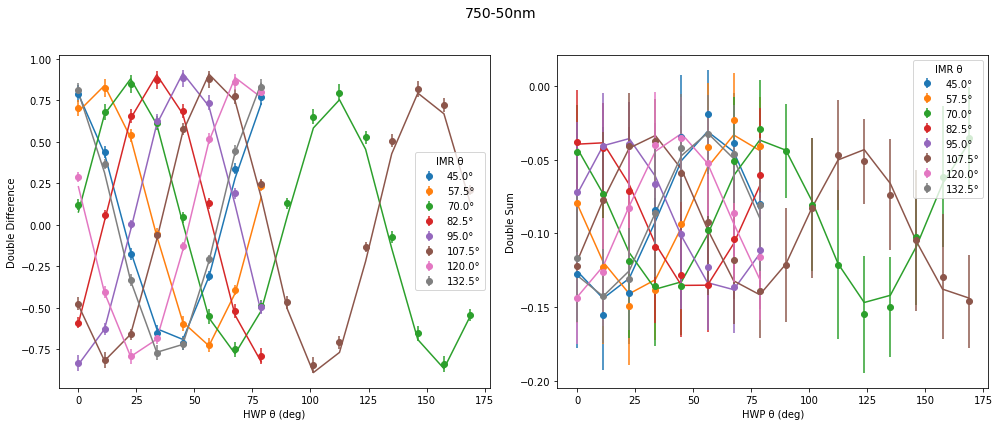

After p0: {'wollaston': {'transmission_ratio': 1.1812325064378395}, 'dichroic': {'phi': 0.6966346307471423, 'epsilon': 0.007999030079043597, 'theta': -10.98774731828971}, 'flc': {'phi': 3.4397781406337082, 'delta_theta': 4.9902614521613025}, 'optics': {'phi': 1.7003138266178897, 'epsilon': 2.44724784720538e-14, 'theta': -2.5543296976928214}, 'image_rotator': {'phi': 3.0709336154734235}, 'hwp': {'phi': 3.0031905831402104, 'delta_theta': 4.997425598937602}, 'lp': {'theta': 0.2453339676817342}}
Before p0: {'wollaston': {'transmission_ratio': 1.1812325064378395}, 'dichroic': {'phi': 0.6966346307471423, 'epsilon': 0.007999030079043597, 'theta': -10.98774731828971}, 'flc': {'phi': 3.4397781406337082, 'delta_theta': 4.9902614521613025}, 'optics': {'phi': 1.7003138266178897, 'epsilon': 2.44724784720538e-14, 'theta': -2.5543296976928214}, 'image_rotator': {'phi': 3.0709336154734235}, 'hwp': {'phi': 3.0031905831402104, 'delta_theta': 4.997425598937602}, 'lp': {'theta': 0.2453339676817342}}
Itera

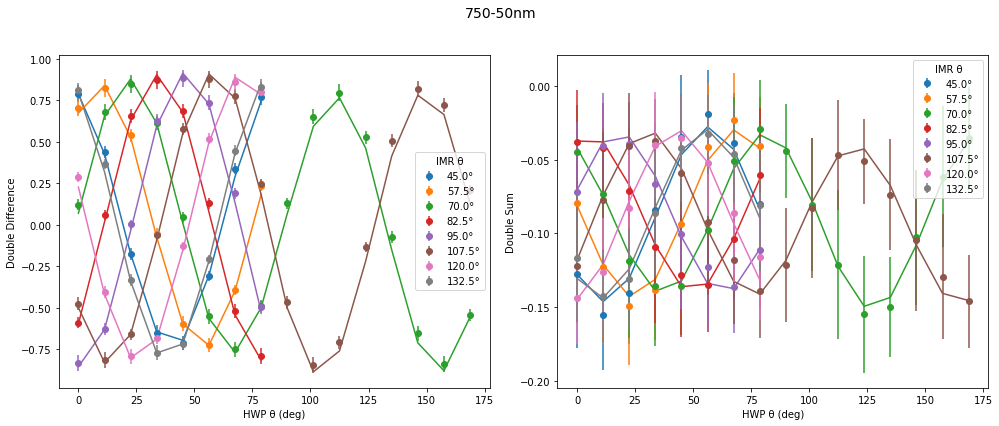

After p0: {'wollaston': {'transmission_ratio': 1.1001352038415404}, 'dichroic': {'phi': 0.448444334050615, 'epsilon': 0.05712983120625209, 'theta': -21.35991763856849}, 'flc': {'phi': 3.550366136616981, 'delta_theta': 4.978064951300922}, 'optics': {'phi': 1.4690724008361968, 'epsilon': 4.1899103978210463e-14, 'theta': -3.4743752615418053}, 'image_rotator': {'phi': 3.0784583762930087}, 'hwp': {'phi': 2.9973388333790325, 'delta_theta': 4.704693696896042}, 'lp': {'theta': 4.305355498495597}}
Before p0: {'wollaston': {'transmission_ratio': 1.1001352038415404}, 'dichroic': {'phi': 0.448444334050615, 'epsilon': 0.05712983120625209, 'theta': -21.35991763856849}, 'flc': {'phi': 3.550366136616981, 'delta_theta': 4.978064951300922}, 'optics': {'phi': 1.4690724008361968, 'epsilon': 4.1899103978210463e-14, 'theta': -3.4743752615418053}, 'image_rotator': {'phi': 3.0784583762930087}, 'hwp': {'phi': 2.9973388333790325, 'delta_theta': 4.704693696896042}, 'lp': {'theta': 4.305355498495597}}
Iteration #

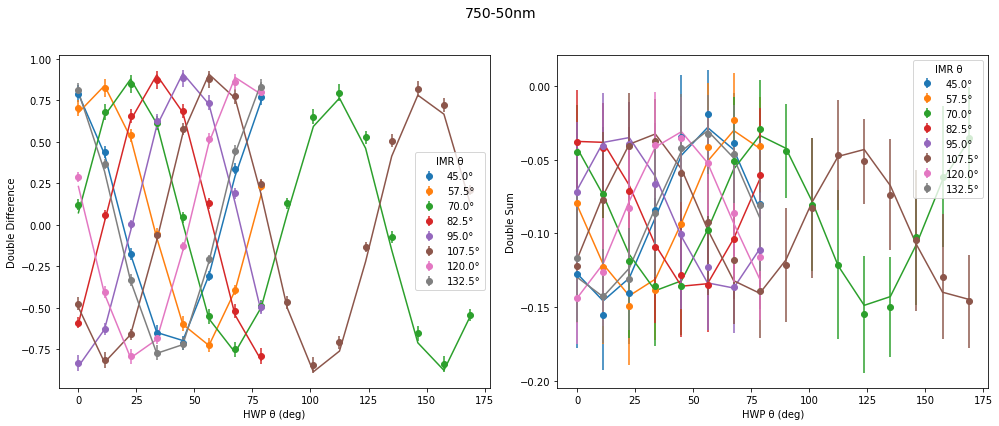

After p0: {'wollaston': {'transmission_ratio': 1.0828225566195386}, 'dichroic': {'phi': 0.7862801778133213, 'epsilon': 0.05531068820953189, 'theta': -12.925342551659114}, 'flc': {'phi': 3.5680565693727475, 'delta_theta': 4.7589573115734325}, 'optics': {'phi': 1.3787258519831789, 'epsilon': 2.948814172692918e-15, 'theta': -2.5141103963573332}, 'image_rotator': {'phi': 3.0762894413855033}, 'hwp': {'phi': 2.9989596271627486, 'delta_theta': 2.0263106422009267}, 'lp': {'theta': 1.2434620117388722}}


In [14]:
# Unpolarized light for s_in as there is LP in the system already
s_in = np.array([1, 0, 0, 0])
bounds = [ 
    (0, 2),  # em_gain
    (-2 * np.pi, 2 * np.pi), # dichroic_retardance
    (0, 1), # dichroic_diattenuation
    (-90, 90), # dichroic_rotation_angle 
    (0.4 * 2 * np.pi, 0.6 * 2 * np.pi),  # delta_FLC
    (-5, 5),  # rot_FLC
    (-np.pi, np.pi),  # delta_opts
    (0, 0.1),  # epsilon_opts
    (-90, 90),  # rot_opts
    ((delta_derot - delta_derot * 0.1) * 2 * np.pi, (delta_derot + delta_derot * 0.1) * 2 * np.pi),  # delta_derot
    # (-1, 1),  # offset_derot
    ((delta_HWP - delta_HWP * 0.1) * 2 * np.pi, (delta_HWP + delta_HWP * 0.1) * 2 * np.pi),  # delta_HWP
    (-5, 5),  # offset_HWP
    (-5, 5),  # theta_pol
]
# Counters for iterative fitting
iteration = 1
previous_logl_value = 1000000
new_logl_value = 0

while abs(previous_logl_value - new_logl_value) > 0.01 * abs(previous_logl_value):
    print("Before p0: " + str(p0))
    if iteration > 1: 
        previous_logl_value = new_logl_value
    result, new_logl_value = inst.minimize_system_mueller_matrix(p0, system_mm, 
        interleaved_values, interleaved_stds, configuration_list, s_in = s_in,
        process_dataset = inst.process_dataset, 
        process_errors = inst.process_errors, 
        process_model = inst.process_model, bounds = bounds)
    
    # Print statements
    print("Iteration #: " + str(iteration))
    print("logl_value: " + str(new_logl_value))
    print("Best Fit Parameters: " + str(result.x))

    # Making a plot
    updated_system_mm = inst.update_system_mm(result.x, p0_keywords, system_mm)
    model = inst.model(result.x, p0_keywords, updated_system_mm, configuration_list, 
    process_model = inst.process_model)

    inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
        configuration_list, wavelength = wavelength_string)

    # Updating p0 for next time
    inst.update_p0(p0, result.x)
    print("After p0: " + str(p0))

    iteration += 1

    filename = f"{wavelength_string}_restrictive_HWP_FLC_no_IMR_offset_with_dichroic_best_fit_old_fit_values.txt"
    with open(filename, 'w') as f:
        json.dump(p0, f, indent=4)

# Step 6: Plot model with best fit

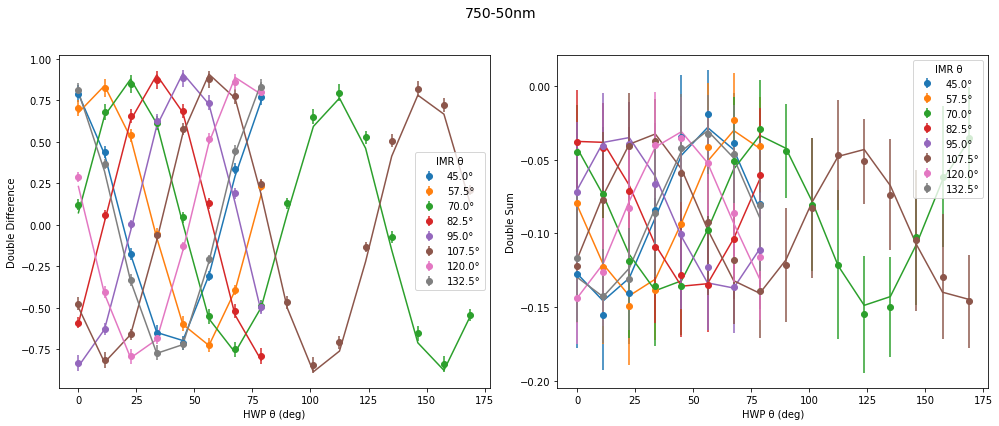

In [15]:
# Generate model with p0 keywords but scipy minimized results
# print(result.x)
# print(p0_keywords)

# Manually adjusting for a good fit
dichroic_phi = 0 # (waves)
dichroic_theta = 0 # (degrees)
# result.x = [2 * np.pi * dichroic_phi, dichroic_theta]

updated_system_mm = inst.update_system_mm(result.x, p0_keywords, system_mm)
model = inst.model(result.x, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)

inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
    configuration_list, wavelength = wavelength_string)